# Monocular Depth Estimation

For the **monocular depth estimation** task, we want to predict a precise estimation for the distance of every pixel of a given image, with respect to the camera's position. This is not an easy task, as due to the nature of projective geometry, the two-dimensional image already lost the depth information. So given the following image, the ground truth looks like the following:

#### Boilerplate Code for Dataset

In [25]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
from lib.data.nyu import NYUv2Dataset

In [9]:
def plot_img_and_depth(x, y):
    x, y = x.permute(1, 2, 0), y.permute(1, 2, 0)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x)
    ax2.imshow(y, cmap='Spectral')
    plt.show() 

In [10]:
transforms = T.Compose([
    T.ToPILImage(),
    T.Resize(256, antialias=True),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
target_transforms = T.Compose([
    T.Resize(256, antialias=True),
    T.CenterCrop(224),
])

dataset = NYUv2Dataset(
    '/Users/tobias/data/monocular_depth_estimation/nyu/nyu_depth_v2_labeled.mat',
    transform=transforms,
    target_transform=target_transforms
)

#### Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


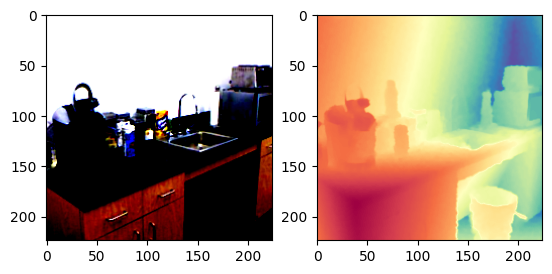

In [11]:
i = np.random.randint(0, len(dataset))
x, y = dataset.__getitem__(i)
dataset.close()

plot_img_and_depth(x, y)

The training data $X$ consists of $N$ images of size $(W\times H\times C)$, where $H$ denotes the image height, $W$ denotes the image width, and $C$ denotes the channels, in this case $3$ for each RGB value, respectively. The labels $Y$, on the other hand, consist of depth maps of size $H\times W\times 1)$. Every value of the depth map is of type `float32` and represents the distance of the pixel, relatively to the camera. Note that a point at infinity is represented as `0.0`.

### NYUv2

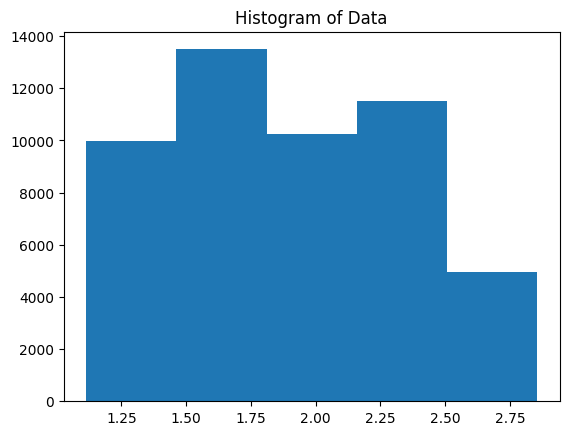

In [17]:
plt.hist(y.flatten(), bins=5)
plt.title('Histogram of Data')

_ = plt.plot()

### The Loss Function

Let's keep it simple and use the loss function `RMSE`. Some approaches use stuff like `binning` (tbd). The Mean Squared Error is a simple error, describing the avarage loss of the euclidean distance. It is defined as follows:
$$
C(y, \tilde{y}) = \sqrt{\frac{1}{N}\sum_{y}{(\tilde{y} - y)^2}}
$$

In [18]:
import torch

def RMSE(y, y_tilde):
    return torch.sqrt(torch.mean((y_tilde - y)**2))

In [21]:
# Random
Y = y
Y_tilde = torch.rand(Y.shape) # FROM, TO, VAR? 0-100 (uniform) 
print(f'MSE (randomly): {RMSE(Y, Y_tilde)}')
Y_tilde = torch.zeros(Y.shape)
print(f'RMSE (zeros): {RMSE(Y, Y_tilde)}')

MSE (randomly): 1.497511386871338
RMSE (zeros): 1.9508200883865356


### Let's try a pretrained model, called MIDAS.

Using cache found in /Users/tobias/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/tobias/.cache/torch/hub/intel-isl_MiDaS_master


TypeError: Invalid shape (3,) for image data

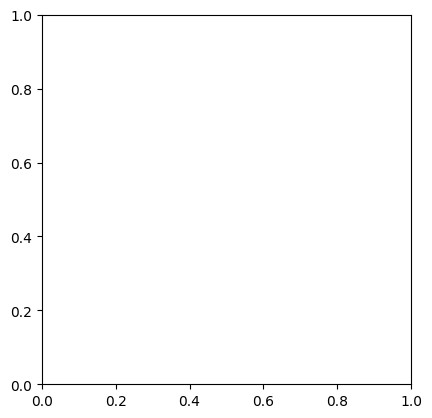

In [27]:
import cv2

midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

#img = cv2.imread('/Users/tobias/data/5Safe/peter_paul/images/DJI_0481.JPG_resized.JPG')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = x.unsqueeze(0)

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform
#input_batch = transform(img).to(device)
input_batch = img.to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

plt.imshow(output)

In [12]:
RMSE(Y, prediction.unsqueeze(-1))

tensor(22.4965)

### So far, we have only done this for one example. Let's calculate this for the whole dataset.